In [79]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from sklearn import cross_validation
import numpy as np
import pandas as pd
from sklearn import preprocessing

In [80]:
df = pd.read_excel("data0505.xlsx",header=0)
# clean up data
df = df.dropna(how = 'all')
df = df.fillna(0)
df = df.round(4)
df=df[df['Power']>=0]
df=df[df['SOC']>0]
df=df[df['SOH']>0]
df=df[df['SEI_delta']>0]
df.head()

,SOC,SOH,Power,T,SEI_after,SEI_delta
10,80,1.0,0.0526,23,0.0,44.8776
11,80,1.0,0.1579,23,0.0,46.1896
12,80,1.0,0.2632,23,0.0,47.5605
13,80,1.0,0.3684,23,0.0,48.9998
14,80,1.0,0.4737,23,0.0,50.4819


In [81]:
min_sei = min(df.iloc[:,5])
max_sei = max(df.iloc[:,5])
min_sei
max_sei
range_sei = max_sei-min_sei

# 
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.head()

,0,1,2,3,4,5
0,1.0,0.0,0.000000,0.0,0.0,0.067068
1,1.0,0.0,0.111146,0.0,0.0,0.153487
2,1.0,0.0,0.222293,0.0,0.0,0.243787
3,1.0,0.0,0.333333,0.0,0.0,0.338592
4,1.0,0.0,0.444480,0.0,0.0,0.436216


In [82]:
x = np.array(df_normalized.iloc[:,0:3])#first three column are SoC, SoH, power
y = np.array(df_normalized.iloc[:,5])#delta SEI
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
x, y, test_size=0.2, random_state=42)
total_len = X_train.shape[0]
total_len

4872

In [83]:
from sknn.mlp import Regressor, Layer
nn = Regressor(
    layers=[
        Layer("Rectifier", units=10),
        Layer("Linear")],
    learning_rate=0.02,
    n_iter=100)

nn.fit(X_train, Y_train)

Regressor(batch_size=1, callback=None, debug=False, dropout_rate=None,
     f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: frozen=False, units=10, name='hidden0'>,
     layers=[<sknn.nn.Layer `Rectifier`: frozen=False, units=10, name='hidden0'>, <sknn.nn.Layer `Linear`: frozen=False, units=1, name='output'>],
     learning_momentum=0.9, learning_rate=0.02, learning_rule='sgd',
     loss_type=None, n_iter=100, n_stable=10, normalize=None,
     output=<sknn.nn.Layer `Linear`: frozen=False, units=1, name='output'>,
     parameters=None, random_state=None, regularize=None, valid_set=None,
     valid_size=0.0, verbose=None, warning=None, weight_decay=None)

In [97]:
print ("Results of SKNN Regression....")
print ("==============================\n")
# The coefficients
# print('Coefficients: ', nn.coef_)
# The mean square error
print("Absolute Percentage error: %.4f"
      % np.mean(abs(nn.predict(X_test) - Y_test)/Y_test))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.4f' % nn.score(X_test, Y_test))

Results of SKNN Regression....

Absolute Percentage error: 1.5228
Variance score: 0.9990


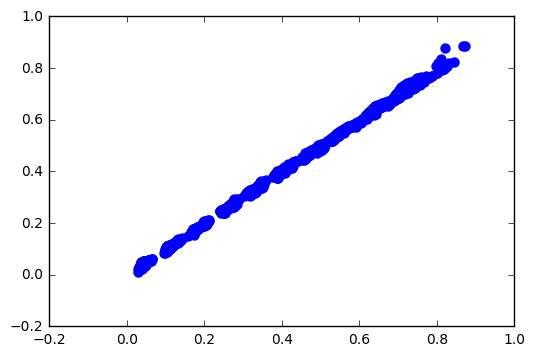

In [85]:
# Plot outputs
plt.scatter(nn.predict(X_test), Y_test, color='blue',
         linewidth=3)
#plt.ylim([40,60])
#plt.xlim([40,60])
plt.show()

In [86]:
ypred=pd.DataFrame(np.array(nn.predict(X_test)))

In [62]:
ypred.to_csv('ypred.csv')

In [63]:
ytest=pd.DataFrame(Y_test)

In [64]:
ytest.to_csv('ytest.csv')

In [87]:
E = 1; # battery energy
P = 1; # battery power
T = 1800; # 1 hour, resolution 4 seconds
ts = 2/3600;

In [88]:
## Constant instruction signal
soc_arr = [0.2]; #initial SoC 0.2
soh_arr = [10**(-8)]; #initial SoH 1e-8
power_arr = [0.6]; #constant power instruction 0.6
for i in range(T):
    state = [soc_arr[i],soh_arr[i],power_arr[i]]
    state = np.array(state);
    delta_soh = ((nn.predict(state.reshape(1, -1))*range_sei)+min_sei)*10**(-16)  #calculate the thickness change
    soh_new = soh_arr[-1]+delta_soh; # new SoH = previous SoH + thickness change
    soh_arr.append(soh_new)
    soc_new = soc_arr[-1]+(power_arr[-1]*ts)/E #new SoC = previous SoC + energy charged
    soc_arr.append(soc_new)
    power_new = 0.6
    power_arr.append(power_new)

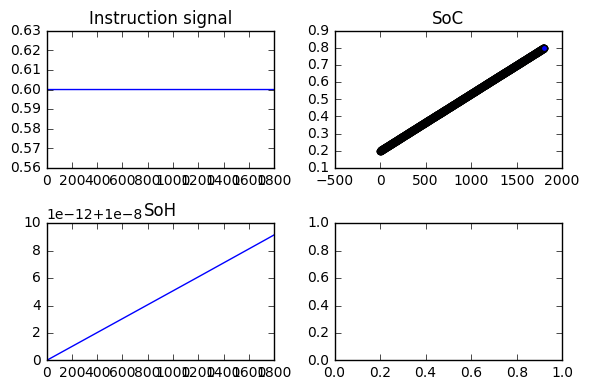

In [89]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(range(T), power_arr[0:T])
axarr[0, 0].set_title('Instruction signal')
axarr[0, 1].scatter(range(T), soc_arr[0:T])
axarr[0, 1].set_title('SoC')
axarr[1, 0].plot(range(T), soh_arr[0:T])
axarr[1, 0].set_title('SoH')
plt.subplots_adjust(left= 0.125, right = 0.9, bottom = 0.1, top = 0.9 , wspace = 0.2, hspace = 0.2 )
plt.tight_layout()
plt.show()

In [91]:
soh_arr

[1e-08,
 array([[  1.00000051e-08]]),
 array([[  1.00000101e-08]]),
 array([[  1.00000152e-08]]),
 array([[  1.00000203e-08]]),
 array([[  1.00000253e-08]]),
 array([[  1.00000304e-08]]),
 array([[  1.00000355e-08]]),
 array([[  1.00000405e-08]]),
 array([[  1.00000456e-08]]),
 array([[  1.00000506e-08]]),
 array([[  1.00000557e-08]]),
 array([[  1.00000608e-08]]),
 array([[  1.00000658e-08]]),
 array([[  1.00000709e-08]]),
 array([[  1.00000760e-08]]),
 array([[  1.00000810e-08]]),
 array([[  1.00000861e-08]]),
 array([[  1.00000912e-08]]),
 array([[  1.00000962e-08]]),
 array([[  1.00001013e-08]]),
 array([[  1.00001064e-08]]),
 array([[  1.00001114e-08]]),
 array([[  1.00001165e-08]]),
 array([[  1.00001215e-08]]),
 array([[  1.00001266e-08]]),
 array([[  1.00001317e-08]]),
 array([[  1.00001367e-08]]),
 array([[  1.00001418e-08]]),
 array([[  1.00001469e-08]]),
 array([[  1.00001519e-08]]),
 array([[  1.00001570e-08]]),
 array([[  1.00001621e-08]]),
 array([[  1.00001671e-08]]),
 a

In [92]:
result = pd.DataFrame(np.array(soh_arr), columns=["delta"])
result.to_csv('nn.csv')


In [93]:
## Sine wave instruction signal
soc_arr = [0.6];
soh_arr = [10**(-8)];
power_arr = [0];
for i in range(T):
    if(power_arr[i]>=0):
        state = [soc_arr[i],soh_arr[i],power_arr[i]]
        state = np.array(state);
        delta_soh = ((nn.predict(state.reshape(1, -1))*range_sei)+min_sei)*10**(-16)
    else:
        delta_soh = 0
    soh_new = soh_arr[-1]+delta_soh;
    soh_arr.append(soh_new)
    soc_new = soc_arr[-1]+(power_arr[-1]*ts)/E
    soc_arr.append(soc_new)
    power_new = np.sin(2*np.pi*(i+1)*2/600)
    power_arr.append(power_new)

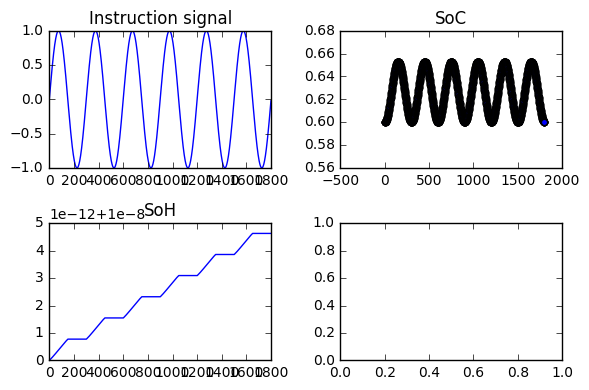

In [94]:
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(range(T), power_arr[0:T])
axarr[0, 0].set_title('Instruction signal')
axarr[0, 1].scatter(range(T), soc_arr[0:T])
axarr[0, 1].set_title('SoC')
axarr[1, 0].plot(range(T), soh_arr[0:T])
axarr[1, 0].set_title('SoH')
plt.subplots_adjust(left= 0.125, right = 0.9, bottom = 0.1, top = 0.9 , wspace = 0.2, hspace = 0.2 )
plt.tight_layout()
plt.show()
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots

In [95]:
nn_sine = pd.DataFrame(np.array(soh_arr), columns=["delta"])
nn_sine.to_csv('nn_sine.csv')


In [72]:

sine=pd.read_csv('sin_delta_new.csv',header=None,names=["time","delta"])
sine.delta.tail()

196    1.000399e-08
197    1.000399e-08
198    1.000399e-08
199    1.000399e-08
200    1.000399e-08
Name: delta, dtype: float64

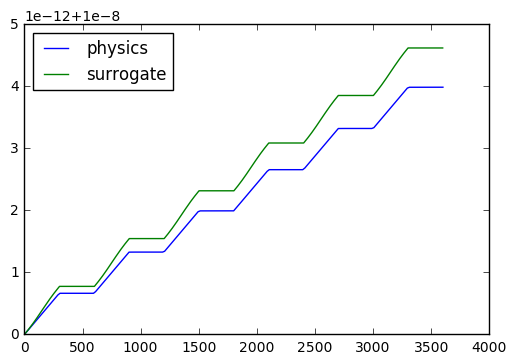

In [73]:
plt.plot(sine.time,sine.delta,label="physics")
plt.plot(range(0,3600,2), soh_arr[0:T],label="surrogate")
plt.legend(loc='upper left')
plt.autoscale(False)
plt.ylim((1e-8, 5*1e-12+1e-8))
#plt.ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e-8))
#plt.ylim([])
plt.show()